In [500]:
import cv2 as cv2
import numpy as np

import matplotlib.pyplot as plt 

from skimage.morphology import remove_small_holes
from skimage.morphology import remove_small_objects

from skimage import io
from skimage.feature import canny
from skimage.transform import rescale
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import ProjectiveTransform, warp, AffineTransform

#import sys
#import math

In [858]:
img = cv2.imread('/content/drive/MyDrive/Intro to CV/HW 2/train_4.jpg')
img_orig = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

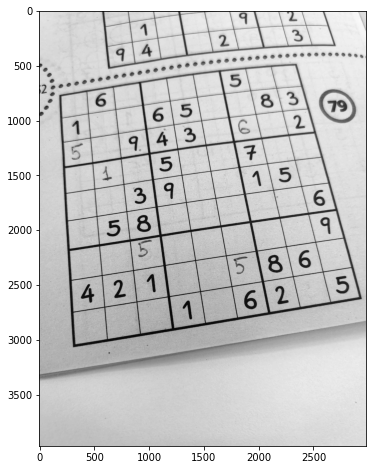

In [859]:
plt.figure(figsize=(12,8))
plt.imshow(gray, cmap="gray")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  """


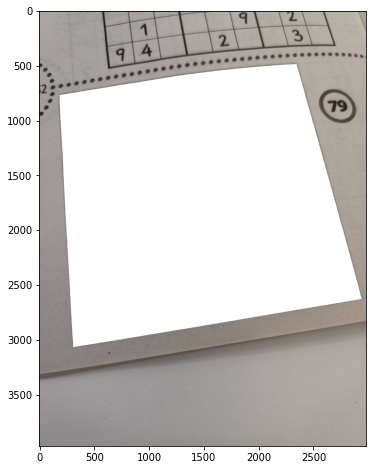

In [860]:
blur = cv2.medianBlur(gray, 3)

thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 3)

thresh = remove_small_holes(thresh, area_threshold= 180, connectivity=2, in_place=False)
thresh = remove_small_objects(thresh, min_size = 300, connectivity=2, in_place=False)
thresh = thresh.astype(np.uint8)

kernel = np.ones((15,15))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

img_cnt = img_orig.copy()

if len(cnts) != 0:
    #find the biggest area
    c = max(cnts, key = cv2.contourArea)

    # filling in the biggest area
    cv2.fillPoly(img_cnt, pts =[c], color=(255,255,255))

    # trying to find the 2nd sudoku on the picture
    cntsSorted = sorted(cnts, key=cv2.contourArea)
    c_second = cnts[1]

    # checking the size of potential second sudoku on the picture
    if cv2.contourArea(c_second) >= 0.725 * cv2.contourArea(c): 
      cv2.fillPoly(img_cnt, pts =[c_second], color=(255,255,255))      

    x,y,w,h = cv2.boundingRect(c)
    # draw the book contour (in blue)
    #cv2.rectangle(img_cnt,(x,y),(x+w,y+h),(0,0,255), 7)

#cv2.drawContours(img_cnt, cnts, -1, (0,255,0), 5)
plt.figure(figsize=(12,8))
plt.imshow(img_cnt)

In [861]:
print(x,y,w,h)

186 483 2752 2584


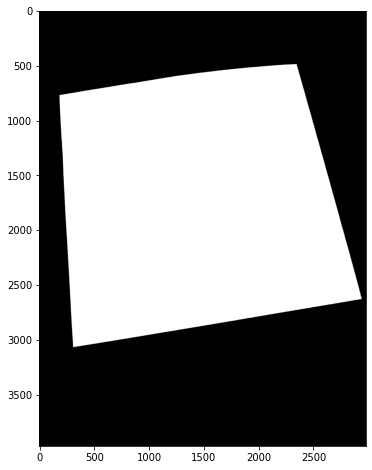

In [862]:
img_cnt[img_cnt != 255] = 0
plt.figure(figsize = (12,8))
plt.imshow(img_cnt)

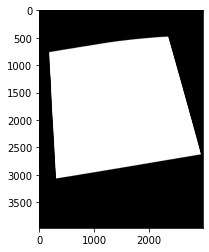

In [863]:
mask = img_cnt
mask = mask[:,:,0] + mask[:,:,1] + mask[:,:,2]
mask[mask != 0] = 1
plt.imshow(mask, cmap = "gray")

(3968, 2976)


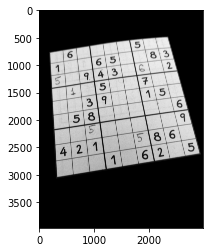

In [864]:
# applying projective transform

# we can apply mask to the original image (gray colors) in order to avoid outliers in transformation
img_transform_color = img_orig.copy()
img_transform = cv2.cvtColor(img_transform_color, cv2.COLOR_RGB2GRAY)
print(img_transform.shape)
img_transform[mask == 0] = 0
plt.imshow(img_transform, cmap = 'gray')

In [865]:
# detecting edges

In [866]:
len(c)

2696

In [867]:
perimeter = cv2.arcLength(c, True) 
perimeter

9844.970020771027

In [868]:
epsilon = 0.01 * perimeter
approx = cv2.approxPolyDP(c,epsilon,True)
approx

array([[[2342,  483]],

       [[ 186,  768]],

       [[ 311, 3066]],

       [[2937, 2625]]], dtype=int32)

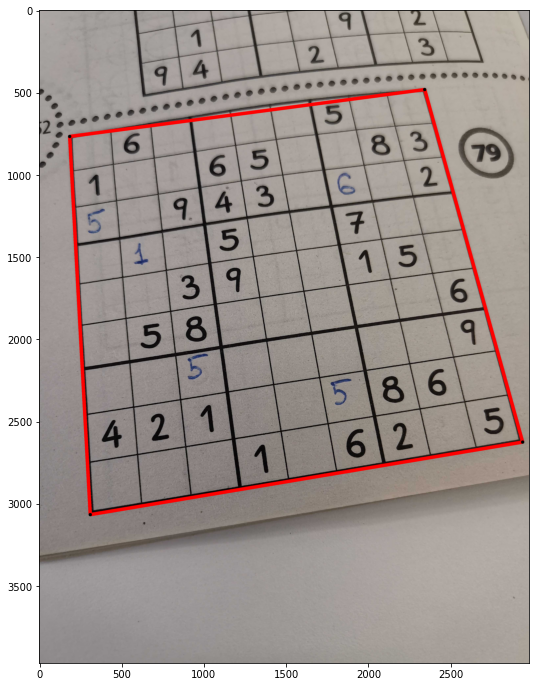

In [869]:
img_r = img_transform_color.copy()
cv2.drawContours(img_r, [approx], 0, (255,0,0), 20)
cv2.drawContours(img_r, approx, -1, (0,0,0), 20)
plt.figure(figsize = (12,12))
plt.imshow(img_r)

In [870]:
approx = approx.reshape(approx.shape[0], approx.shape[2])
approx = approx.tolist()
approx

[[2342, 483], [186, 768], [311, 3066], [2937, 2625]]

In [871]:
# нужно сделать преобразование списка координат в порядке (х1у1, х2у2, х3у3, х4у4), против часовой
# при этом x1y1 - наименьшие, x3y3 - наибольшие значения

In [872]:
# делаем через сумму Х и У в каждой координате
# наименьшая сумма - у х1у1, наибольшая - х3у3
# х2у2 и х4у4 могут сравниваться по х или же по у (по остаточному принципу, поскольку х1у1 и х3у3 уже будут распределены)

In [873]:
approx

[[2342, 483], [186, 768], [311, 3066], [2937, 2625]]

In [874]:
np.sqrt(approx[1][0]**2 + approx[1][1]**2)

790.2025056907881

In [875]:
max_coord_sum = 500
min_coord_sum = 100000

for i in range(len(approx)):
  # maximum and minimum euclidean distance (max - x3y3, min - x1y1)
  if np.sqrt(approx[i][0]**2 + approx[i][1]**2) > max_coord_sum:
    max_coord_sum = np.sqrt(approx[i][0]**2 + approx[i][1]**2)
    x3y3 = approx[i]
  if np.sqrt(approx[i][0]**2 + approx[i][1]**2) < min_coord_sum:
    min_coord_sum = np.sqrt(approx[i][0]**2 + approx[i][1]**2)
    x1y1 = approx[i]

# x2y2 and x4y4
for i in range(len(approx)):
  if (approx[i] != x1y1) and (approx[i] != x3y3) and (approx[i][0] < x3y3[0]) and (approx[i][1] > x1y1[1]):
    x2y2 = approx[i]
  if (approx[i] != x1y1) and (approx[i] != x3y3) and (approx[i][0] > x1y1[0]) and (approx[i][1] < x3y3[1]):
    x4y4 = approx[i]

coordinates_transform[0] = x1y1
coordinates_transform[1] = x2y2
coordinates_transform[2] = x3y3
coordinates_transform[3] = x4y4

coordinates_transform

array([[ 186.,  768.],
       [ 311., 3066.],
       [2937., 2625.],
       [2342.,  483.]])

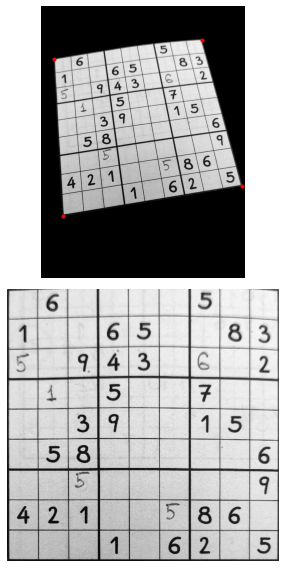

In [876]:
src = np.array([[0, 0], [0, 500], [500, 500], [500, 0]])
dst = np.array(coordinates_transform.tolist())

tform3 = transform.ProjectiveTransform()
tform3.estimate(src, dst)
warped = transform.warp(img_transform, tform3, output_shape=(500, 500))

fig, ax = plt.subplots(nrows=2, figsize=(8, 8))

ax[0].imshow(img_transform, cmap=plt.cm.gray)
ax[0].plot(dst[:, 0], dst[:, 1], '.r')
ax[1].imshow(warped, cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()